In [ ]:
! nvcc --version
! nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Sat Dec 26 20:20:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+

In [ ]:
import os
if not os.path.exists('/content/content/list_folders'):
  !unzip "/content/drive/MyDrive/30 FPS LIST.zip"

In [ ]:
#helper methods

def rotatex(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx
def rotatey(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qy
outIndex = 0
from numpy import percentile
def outlier (data):
  outIndex = 0
  outList = []
  # calculate interquartile range
  q25, q75 = percentile(data, 25), percentile(data, 75)
  iqr = q75 - q25
  cut_off = iqr * 1.5
  lower, upper = q25 - cut_off, q75 + cut_off
  # identify outliers
  for x in data:
    if x < lower or x > upper:
      outList.append(outIndex)
    outIndex = outIndex + 2
  return outList
def outlier2 (data):
  outIndex = 0
  outList = []
  # calculate interquartile range
  q25, q75 = percentile(data, 25), percentile(data, 75)
  iqr = q75 - q25
  cut_off = iqr * 1.5
  lower, upper = q25 - cut_off, q75 + cut_off
  # identify outliers
  for x in data:
    if x < lower or x > upper:
      outList.append(outIndex)
    outIndex = outIndex + 1
  return outList
import os
counter = 0
for file in os.walk('/content/drive/My Drive/lights/Right'):
  counter += 1
for file in os.walk('/content/drive/My Drive/lights/Left'):
  counter += 1

In [ ]:
#preprocess the data to make it easier for the model to learn from. Includes correctly ordering the 2 fencers in the array, removing outliers and mistakes from the openpose model
#centering/resizing the fenceres to be consistent across clips, rotating the fencers to be level, and other small fixes



import pickle
import numpy as np
from numpy import percentile
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math 
from random import randint
from math import sqrt, cos, sin
import statistics
import warnings
warnings.simplefilter('ignore', np.RankWarning)
X=[]
Y=[]
nameList = []
left=0
right=0
lessthan60 = 0
for root, dirs, files in os.walk('/content/content/list_folders'):
  for name in files:
      if name.endswith((".txt")):
          with open (root+'/'+name, 'rb') as fp:
            itemlist = pickle.load(fp)
            if len(itemlist) > 20:
              arr2 = np.array(itemlist)
              counter = 10
              onlyFrames = []
              yList = []
              yMin1 = []
              yMin2 = []
              frameBefore = itemlist[0]
              for frame in itemlist:
                q25, q75 = percentile(frame[1::2], 25), percentile(frame[1::2], 75)
                onlyFrames.append(q75-q25)
              for frame in itemlist:
                yCounter = 1
                xCounter = 0
                for x in range (0,int(len(frame)/2),1):
                  ydistance = 180-frame[yCounter]
                  frame[yCounter] = frame[yCounter] + ydistance*2
                  xCounter = xCounter +2
                  yCounter = yCounter+2
                if frame [2] > frame[52]:
                  temp=[]
                  for item in range(49,-1,-1):
                    temp.append(frame.pop(item)) 
                  temp.reverse()
                  frame.extend(temp)

                if frame[8] < frame[14]:    #### right arm always first
                  arm1=frame[4:10]
                  arm2=frame[10:16]
                  frame[4:10]=arm2
                  frame[10:16]=arm1

                if frame[58] > frame[64]:    #### left arm always first
                  arm1=frame[54:60]
                  arm2=frame[60:66]
                  frame[54:60]=arm2
                  frame[60:66]=arm1

                if frame[22] < frame[28]:
                  leg1=frame[18:24]
                  leg2=frame[24:30]
                  frame[18:24]=leg2
                  frame[24:30]=leg1
                  foot1=frame[44:50]
                  foot2=frame[38:44]
                  frame[44:50]=foot2
                  frame[38:44]=foot1
                if frame[72] > frame[78]:
                  leg1=frame[68:74]
                  leg2=frame[74:80]
                  frame[68:74]=leg2
                  frame[74:80]=leg1
                  foot1=frame[94:100]
                  foot2=frame[88:94]
                  frame[94:100]=foot2
                  frame[88:94]=foot1
                
                #remove unnecesary data
                indexes=[30,31,80,81,32,33,82,83,34,35,84,85,36,37,86,87,40,41,90,91,42,43,92,93,46,47,96,97,48,49,98,99, 0,1,50,51, 
                                16,17,66,67, 2,3,52,53, 38,39,44,45,88,89,94,95,]
                for index in sorted(indexes, reverse=True):
                    del frame[index]
                
                #remove outliers
                outList = outlier(frame[:24:2])  
                outList = outList + [x+24 for x in (outlier(frame[24::2]))] 
                outList = outList + [y+1 for y in (outlier(frame[1:24:2]))] 
                outList = outList + [y+24+1 for y in (outlier(frame[25::2]))] 
                outList2=[]
                for index in outList:
                  if (index % 2) == 0:
                    outList2.append(index+1)
                  else:
                    outList2.append(index-1)
                outList = outList + outList2
                outList = list(set(outList))   
                for index in outList:
                  frame[index] = 0

                #remove individual frames that are most likely incorrect (outlier detection)
                yCounter = 1
                xCounter = 0
                Distance = 0
                y1 = statistics.median(frame[1:24:2])
                y2 = statistics.median(frame[25::2])
                y1before = statistics.median(frameBefore[1:24:2])
                y2before = statistics.median(frameBefore[25::2])
                if abs(y1-y1before) > 90 or abs(y2-y2before) > 90:
                  frame[::] = [0]*48                                        
                else:     #else to prevent removing all frames after an outlier 
                  frameBefore = frame
                if frame != [0]*48:                                          
                  yMin1.append(statistics.median([x for x in frame[1:24:2] if x != 0]))
                  yMin2.append(statistics.median([x for x in frame[25::2] if x != 0]))
                yList.extend([i for i in frame[1::2] if i != 0])
              
              #rescaling/resizing/centering the fencers
              hfactor = 1
              if statistics.median(yMin1) > statistics.median(yMin2):
                  hfactor = statistics.median(yMin1)/(statistics.median(yMin2))
              if statistics.median(yMin1) < statistics.median(yMin2):
                  hfactor = statistics.median(yMin2)/(statistics.median(yMin1))
              factor = 100/statistics.median(onlyFrames)
              y_translation = 200-(statistics.median(yList))
              for frame in itemlist:               
                frame[1::2] = [y-180 if y != 0 else y for y in frame[1::2]]
                frame[::2] = [x-320 if x != 0 else x for x in frame[::2]]
                frame[::] = [z*factor for z in frame[::]]
                frame[::2] = [x*hfactor for x in frame[::2]]
                frame[1::2] = [y+180 if y != 0 else y for y in frame[1::2]]
                frame[::2] = [x+320 if x != 0 else x for x in frame[::2]]
                frame[1::2] = [y+y_translation if y != 0  else y for y in frame[1::2]]
                x_translation = 0
                if min(frame[::2]) < 0: 
                  x_translation = 0 - min(frame[::2])
                if max(frame[::2]) > 840: 
                  x_translation = 840-max(frame[::2])
                frame[::2] = [x+x_translation if x != 0 else x for x in frame [::2]]

              #rotating fencers to be level
              yList = []
              Lheight=[]
              Rheight = []
              slope=[]
              intercept = []

              for frame in itemlist:
                if (frame != [0]*48):
                  x5, y5 = [],[]
                  indices=[]
                  x5=([frame[16],frame[22],frame[40],frame[46]])
                  y5=([frame[17],frame[23],frame[41],frame[47]])
                  if (x5 != [0]*4 and y5 != [0]*4):
                    indices = [i for i, x in enumerate(x5) if x == 0]
                    indices += [i for i, x in enumerate(y5) if x == 0]
                    indices = list(set(indices))
                    for index in sorted(indices, reverse=True):
                      del x5[index]
                      del y5[index]
                    
                    m, b = np.polyfit(np.array(x5), np.array(y5), 1)    #slope should be constant, b should be dynamic
                    slope.append(m)
                    intercept.append(b)
                  else:
                    slope.append(m)
                    intercept.append(b)
                else:
                  slope.append(m)
                  intercept.append(b)

              for index in outlier2(slope):
                slope[index] = slope[index-1]
                intercept[index] = intercept[index-1]
              index = 0

              if (abs(np.arctan(statistics.median(slope)))> .1):
                for frame in itemlist:
                  m = slope[index]
                  b = (intercept[index])
                  f = -(np.arctan(m))

                  frame[1::2] = [200+y-(m*frame[frame.index(y)-1]+b) if y != 0 else y for y in frame[1::2]]
 
                  yList.extend([i for i in frame[1::2] if i != 0])
                  index+=1

                yListLeft, yListRight = [],[]
                LeftList, RightList =  [],[]
                  

                LFrame = [x for x in itemlist[0][1:24:2] if x != 0]
                RFrame = [x for x in itemlist[0][25::2] if x != 0]
                if (max(LFrame) - min(LFrame)) != 0 and 100/(max(RFrame) - min(RFrame)) != 0:
                      Lfactor = (100/(max(LFrame) - min(LFrame)))
                      Rfactor = (100/(max(RFrame) - min(RFrame)))
                for frame in itemlist:
                  if frame != [0]*48:

                    LFrame,RFrame = [],[]
                    LFrame = [x for x in frame[1:24:2] if x != 0]
                    RFrame = [x for x in frame[25::2] if x != 0]
                    if (max(LFrame) - min(LFrame)) != 0 and 100/(max(RFrame) - min(RFrame)) != 0:
                      Lfactor = statistics.mean([Lfactor, 100/(max(LFrame) - min(LFrame))])
                      Rfactor = statistics.mean([Rfactor,100/(max(RFrame) - min(RFrame))])
                    frame[1::2] = [y-180 if y != 0 else y for y in frame[1::2]]
                    frame[::2] = [x-320 if x != 0 else x for x in frame[::2]]

                    frame[:24:] = [z*Lfactor for z in frame[:24:]]
                    frame[25::] = [z*Rfactor for z in frame[25::]]
                    frame[1::2] = [y+180 if y != 0 else y for y in frame[1::2]]
                    frame[::2] = [x+320 if x != 0 else x for x in frame[::2]]
                    yListLeft.extend([i for i in frame[1:24:2] if i != 0])
                    yListRight.extend([i for i in frame[25::2] if i != 0])

                leftShift,rightShift = 0,0
                try:
                  leftShift = 200-(statistics.median(yListLeft))
                  rightShift = 200-(statistics.median(yListRight))
                except:
                  leftShift,rightShift = 0,0
                for frame in itemlist:
                  frame[1:24:2] = [z+leftShift if z != 0 else z for z in frame[1:24:2]]
                  frame[25::2] = [z+rightShift if z != 0 else z for z in frame[25::2]]

              #standardizing data to be within range 0-1
              for frame in itemlist:
                frame[::] = [x/840 for x in frame[::]]  

              arr2=np.array(itemlist)

             #append extra data (lights)
              if name [3] == 'L' or name[2] == 'L':
                with open ('/content/drive/My Drive/lights/Left/'+name, 'rb') as fp:
                  lights = pickle.load(fp) 
                  dif = len(lights)-len(itemlist)
                  del lights[:dif]
                  try:
                    arr2 = np.concatenate((arr2,lights), axis = 1)
                  except:
                    print(name)
              else:
                with open ('/content/drive/My Drive/lights/Right/'+name, 'rb') as fp:
                  lights = pickle.load(fp) 
                  dif = len(lights)-len(itemlist)
                  del lights[:dif]
                  try:
                    arr2 = np.concatenate((arr2,lights), axis = 1)
                  except:
                    print(name)
              
              #check for null and if not, add to dataset
              array_sum = np.sum(arr2)
              if np.isnan(array_sum):
                print(name)
              elif arr2.shape == (60,48):

                    listitem=arr2
   
                    nameList.append(name)
                    X.append(listitem)
                    if name [3] == 'L' or name[2] == 'L':
                      Y.append(1)
                      left=left+1
                    else:
                      Y.append(0)        
                      right=right+1
              else:

                  lessthan60 +=1
                    
            else:
              print(name)

print(right)
print(left)
print(lessthan60)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:211: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:213: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:219: RuntimeWarning: invalid value encountered in double_scalars


7-L49-31 (30).txt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:233: RuntimeWarning: invalid value encountered in double_scalars


19-L3-95 (30).txt
7-L19-22 (30)-flipped.txt
16-R41-19 (30).txt
17-R18-2 (30)-flipped.txt
4015
3871
1179


In [ ]:
#saving preprocessed data to file

from google.colab import files
np.save('X (48)', X) # save
np.save('Y (48)', Y) # save

files.download('X (48).npy')
files.download('Y (48).npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#loading in processed data from numpy file

import numpy as np
from sklearn.model_selection import train_test_split

X = np.load('/content/drive/My Drive/X.npy')
Y = np.load('/content/drive/My Drive/Y.npy')

print(X.shape)
print(Y.shape)

(9248, 30, 50)
(9248,)


In [ ]:
#creating training/testing subsets

X=(np.around(np.array(X),3))
X=np.array(X)
nameList=np.array(nameList)
Y=np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True) #was test size = 0.2
print(X_train.shape)
print(X_test.shape)
name_train, name_test, blank_train, blank_test = train_test_split(nameList, Y, test_size=0.1, random_state=42, shuffle = True)

(7097, 60, 48)
(789, 60, 48)


In [2]:
!pip install keras-tcn

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 48)]          0         
_________________________________________________________________
tcn (TCN)                    (None, 10)                4610      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 4,621
Trainable params: 4,621
Non-trainable params: 0
_________________________________________________________________


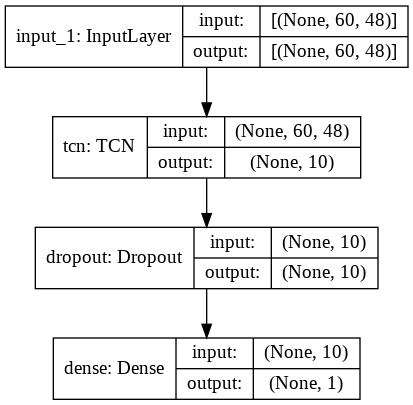

In [3]:
#initalize model

import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Input, Model
from tcn import TCN
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow
from sklearn.ensemble import AdaBoostClassifier
batch_size, timesteps, input_dim = None, 60,48
i = Input(batch_shape=(batch_size, timesteps, input_dim))

dropout = 0.5
neurons = 512
activation = None
regularizer = tensorflow.keras.regularizers.l2(l2=0.001)#None
o = TCN(10,kernel_size = 2 , nb_stacks = 2, dilations = (1, 2, 4,8),return_sequences=False,dropout_rate=0.1)(i) # was .1 #was 10

o = Dropout(0.5)(o) #was .5

o = Dense(1, kernel_regularizer = regularizer, activation='sigmoid')(o)


model = Model(inputs=[i], outputs=[o])


model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate = 0.01, momentum = .0, decay = .01/3000), loss='binary_crossentropy',
    metrics=['acc'])
model.summary()
tensorflow.keras.utils.plot_model(model, "model_architecture.png", show_shapes=True)


In [ ]:
#actually training the model (woohoo!)

EPOCHS=4500
import tensorflow as tf
import os
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from tensorflow.keras.models import Sequential
!rm -rf /content/chkp
if not os.path.exists('chkp'):
	os.makedirs('chkp')

callbacks = [
    #tf.keras.callbacks.ReduceLROnPlateau(verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        '/content/chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1,
        period=250
        )
]


history=model.fit(
    x=X_train,  
    y=Y_train, 
    validation_data=(X_test,Y_test),
    batch_size=128,
    verbose=2,
    epochs=EPOCHS,
    callbacks=callbacks
)



Streaming output truncated to the last 5000 lines.
Epoch 1773/94500
56/56 - 1s - loss: 0.6436 - acc: 0.6207 - val_loss: 0.6306 - val_acc: 0.6426
Epoch 1774/94500
56/56 - 1s - loss: 0.6435 - acc: 0.6208 - val_loss: 0.6275 - val_acc: 0.6375
Epoch 1775/94500
56/56 - 1s - loss: 0.6459 - acc: 0.6201 - val_loss: 0.6326 - val_acc: 0.6439
Epoch 1776/94500
56/56 - 1s - loss: 0.6433 - acc: 0.6217 - val_loss: 0.6307 - val_acc: 0.6324
Epoch 1777/94500
56/56 - 1s - loss: 0.6423 - acc: 0.6272 - val_loss: 0.6384 - val_acc: 0.6375
Epoch 1778/94500
56/56 - 1s - loss: 0.6451 - acc: 0.6215 - val_loss: 0.6288 - val_acc: 0.6464
Epoch 1779/94500
56/56 - 1s - loss: 0.6434 - acc: 0.6229 - val_loss: 0.6320 - val_acc: 0.6451
Epoch 1780/94500
56/56 - 1s - loss: 0.6391 - acc: 0.6267 - val_loss: 0.6270 - val_acc: 0.6375
Epoch 1781/94500
56/56 - 1s - loss: 0.6429 - acc: 0.6308 - val_loss: 0.6286 - val_acc: 0.6464
Epoch 1782/94500
56/56 - 1s - loss: 0.6468 - acc: 0.6267 - val_loss: 0.6296 - val_acc: 0.6489
Epoch 178

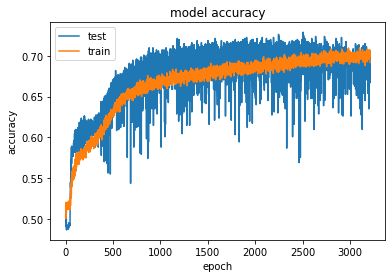

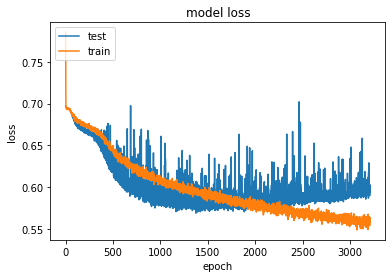

In [ ]:
#visualizing models training/testing loss and accuracy
import matplotlib.pyplot as plt
plt.plot(model.history.history['val_acc'])
plt.plot(model.history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test','train'], loc='upper left')
plt.show()
plt.plot(model.history.history['val_loss'])
plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test','train'], loc='upper left')
plt.show()

In [ ]:
#for visualizing the data and which clips the model labels incorrectly

import matplotlib.pyplot as plt
import os
import moviepy.video.io.ImageSequenceClip
from IPython.display import HTML
from base64 import b64encode
!rm -rf /content/wrong
if not os.path.exists('wrong'):
	os.makedirs('wrong')
model.load_weights('/content/chkp/weights.1500-0.58.hdf5')
for number in range (0, len(Y_test)):
  !rm -rf /content/images
  if not os.path.exists('/content/images'):
      os.makedirs( "/content/images")



  video = X_test[number]

  arr2 = np.reshape(video, (1, 60, 48))
  if np.asscalar(np.around(model.predict(arr2),0)) != Y_test[number]:

    counter = 10
    for frame in video:
        x=frame[::2]
        y=frame[1::2]     
        plt.xlim(0, 1)
        plt.ylim(0, .42857)
        plt.scatter(x, y) 
        plt.savefig('/content/images/'+str(counter)+'.png')
        counter=counter+1
        plt.clf()               
    image_folder='/content/images'
    fps=30
    image_files = [image_folder+'/'+img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
    predict = str(np.around(model.predict(arr2),3)).strip("[").strip("]")
    path = '/content/wrong/' + str(Y_test[number]) + " - " + predict + ' - ' + str(name_test[number])+".mp4"

    print(path)
    clip.write_videofile(path)
    video_path = path
    mp4 = open(video_path, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    HTML(f"""
    <video width=400 controls>
          <source src="{data_url}" type="video/mp4">
    </video>
    """)
  #Left = 1
  #Right = 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


/content/wrong/0 - 0.53 - 25-R9-34 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.53 - 25-R9-34 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.53 - 25-R9-34 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.53 - 25-R9-34 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.466 - 19-L61-113 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.466 - 19-L61-113 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.466 - 19-L61-113 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 133.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.466 - 19-L61-113 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.44 - 4-L35-38 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.44 - 4-L35-38 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.44 - 4-L35-38 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.44 - 4-L35-38 (30).txt.mp4 

/content/wrong/0 - 0.887 - 23-R5-45 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.887 - 23-R5-45 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.887 - 23-R5-45 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.887 - 23-R5-45 (30).txt.mp4 

/content/wrong/1 - 0.399 - 32-L3-36 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.399 - 32-L3-36 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.399 - 32-L3-36 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.399 - 32-L3-36 (30).txt.mp4 

/content/wrong/1 - 0.421 - 10-L37-49 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.421 - 10-L37-49 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.421 - 10-L37-49 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 133.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.421 - 10-L37-49 (30).txt.mp4 

/content/wrong/0 - 0.54 - 22-R19-18 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.54 - 22-R19-18 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.54 - 22-R19-18 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.54 - 22-R19-18 (30).txt.mp4 

/content/wrong/1 - 0.395 - 3-L55-11 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.395 - 3-L55-11 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.395 - 3-L55-11 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.395 - 3-L55-11 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.504 - 17-R12-33 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.504 - 17-R12-33 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.504 - 17-R12-33 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.504 - 17-R12-33 (30).txt.mp4 

/content/wrong/0 - 0.545 - 13-R3-20 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.545 - 13-R3-20 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.545 - 13-R3-20 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.545 - 13-R3-20 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.44 - 4-L58-34 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.44 - 4-L58-34 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.44 - 4-L58-34 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.44 - 4-L58-34 (30).txt.mp4 

/content/wrong/0 - 0.729 - 25-R34-44 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.729 - 25-R34-44 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.729 - 25-R34-44 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.729 - 25-R34-44 (30).txt.mp4 

/content/wrong/1 - 0.157 - 27-L36-39 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.157 - 27-L36-39 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.157 - 27-L36-39 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.157 - 27-L36-39 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.491 - 27-L27-11 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.491 - 27-L27-11 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.491 - 27-L27-11 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.491 - 27-L27-11 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.488 - 21-L52-89 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.488 - 21-L52-89 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.488 - 21-L52-89 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.488 - 21-L52-89 (30).txt.mp4 

/content/wrong/0 - 0.678 - 25-R35-27 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.678 - 25-R35-27 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.678 - 25-R35-27 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.678 - 25-R35-27 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.309 - 32-L14-8 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.309 - 32-L14-8 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.309 - 32-L14-8 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.309 - 32-L14-8 (30).txt.mp4 

/content/wrong/0 - 0.686 - 8-R0-8 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.686 - 8-R0-8 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.686 - 8-R0-8 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.686 - 8-R0-8 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.554 - 27-R48-7 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.554 - 27-R48-7 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.554 - 27-R48-7 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.554 - 27-R48-7 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.541 - 15-R1-8 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.541 - 15-R1-8 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.541 - 15-R1-8 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.541 - 15-R1-8 (30).txt.mp4 

/content/wrong/1 - 0.346 - 25-L53-37 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.346 - 25-L53-37 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.346 - 25-L53-37 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 135.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.346 - 25-L53-37 (30).txt.mp4 

/content/wrong/0 - 0.525 - 22-R59-10 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.525 - 22-R59-10 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.525 - 22-R59-10 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.525 - 22-R59-10 (30).txt.mp4 

/content/wrong/1 - 0.407 - 17-L53-14 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.407 - 17-L53-14 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.407 - 17-L53-14 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.407 - 17-L53-14 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.367 - 21-L23-37 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.367 - 21-L23-37 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.367 - 21-L23-37 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 123.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.367 - 21-L23-37 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.519 - 13-R34-41 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.519 - 13-R34-41 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.519 - 13-R34-41 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 122.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.519 - 13-R34-41 (30).txt.mp4 

/content/wrong/1 - 0.462 - 11-L16-36 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.462 - 11-L16-36 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.462 - 11-L16-36 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.462 - 11-L16-36 (30).txt.mp4 

/content/wrong/1 - 0.32 - 20-L26-49 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.32 - 20-L26-49 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.32 - 20-L26-49 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.32 - 20-L26-49 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.467 - 9-L8-32 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.467 - 9-L8-32 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.467 - 9-L8-32 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.467 - 9-L8-32 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.532 - 8-R30-18 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.532 - 8-R30-18 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.532 - 8-R30-18 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 133.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.532 - 8-R30-18 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.429 - 22-L22-12 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.429 - 22-L22-12 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.429 - 22-L22-12 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.429 - 22-L22-12 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.481 - 13-L20-27 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.481 - 13-L20-27 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.481 - 13-L20-27 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.481 - 13-L20-27 (30).txt.mp4 

/content/wrong/0 - 0.537 - 29-R2-50 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.537 - 29-R2-50 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.537 - 29-R2-50 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.537 - 29-R2-50 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.384 - 15-L42-47 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.384 - 15-L42-47 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.384 - 15-L42-47 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.384 - 15-L42-47 (30).txt.mp4 

/content/wrong/1 - 0.481 - 18-L81-10 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.481 - 18-L81-10 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.481 - 18-L81-10 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.481 - 18-L81-10 (30).txt.mp4 

/content/wrong/0 - 0.666 - 16-R52-44 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.666 - 16-R52-44 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.666 - 16-R52-44 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 135.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.666 - 16-R52-44 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.375 - 18-L36-56 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.375 - 18-L36-56 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.375 - 18-L36-56 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.375 - 18-L36-56 (30).txt.mp4 

/content/wrong/0 - 0.752 - 3-R58-13 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.752 - 3-R58-13 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.752 - 3-R58-13 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.752 - 3-R58-13 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.398 - 22-L21-28 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.398 - 22-L21-28 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.398 - 22-L21-28 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.398 - 22-L21-28 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.246 - 3-L22-45 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.246 - 3-L22-45 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.246 - 3-L22-45 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.246 - 3-L22-45 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.861 - 5-R20-58 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.861 - 5-R20-58 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.861 - 5-R20-58 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.861 - 5-R20-58 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.819 - 22-R51-35 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.819 - 22-R51-35 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.819 - 22-R51-35 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.819 - 22-R51-35 (30).txt.mp4 

/content/wrong/1 - 0.321 - 26-L27-23 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.321 - 26-L27-23 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.321 - 26-L27-23 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.321 - 26-L27-23 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.572 - 10-R53-36 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.572 - 10-R53-36 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.572 - 10-R53-36 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.572 - 10-R53-36 (30).txt.mp4 

/content/wrong/1 - 0.36 - 29-L26-21 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.36 - 29-L26-21 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.36 - 29-L26-21 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.36 - 29-L26-21 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.455 - 20-L57-40 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.455 - 20-L57-40 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.455 - 20-L57-40 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.455 - 20-L57-40 (30).txt.mp4 

/content/wrong/0 - 0.656 - 23-R40-7 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.656 - 23-R40-7 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.656 - 23-R40-7 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.656 - 23-R40-7 (30).txt.mp4 

/content/wrong/0 - 0.713 - 7-R53-29 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.713 - 7-R53-29 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.713 - 7-R53-29 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 133.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.713 - 7-R53-29 (30).txt.mp4 

/content/wrong/0 - 0.507 - 5-R58-38 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.507 - 5-R58-38 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.507 - 5-R58-38 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.507 - 5-R58-38 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.404 - 13-L18-44 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.404 - 13-L18-44 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.404 - 13-L18-44 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.404 - 13-L18-44 (30).txt.mp4 

/content/wrong/1 - 0.386 - 16-L19-43 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.386 - 16-L19-43 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.386 - 16-L19-43 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.386 - 16-L19-43 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.69 - 26-R8-15 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.69 - 26-R8-15 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.69 - 26-R8-15 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.69 - 26-R8-15 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.484 - 7-L27-29 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.484 - 7-L27-29 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.484 - 7-L27-29 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.484 - 7-L27-29 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.547 - 19-R8-38 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.547 - 19-R8-38 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.547 - 19-R8-38 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.547 - 19-R8-38 (30).txt.mp4 

/content/wrong/0 - 0.994 - 18-R82-10 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.994 - 18-R82-10 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.994 - 18-R82-10 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.994 - 18-R82-10 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.489 - 24-L22-18 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.489 - 24-L22-18 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.489 - 24-L22-18 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.489 - 24-L22-18 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.748 - 15-R14-24 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.748 - 15-R14-24 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.748 - 15-R14-24 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 124.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.748 - 15-R14-24 (30).txt.mp4 

/content/wrong/1 - 0.458 - 17-L7-33 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.458 - 17-L7-33 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.458 - 17-L7-33 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.458 - 17-L7-33 (30).txt.mp4 

/content/wrong/1 - 0.316 - 18-L56-21 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.316 - 18-L56-21 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.316 - 18-L56-21 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.316 - 18-L56-21 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.66 - 15-R28-21 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.66 - 15-R28-21 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.66 - 15-R28-21 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.66 - 15-R28-21 (30).txt.mp4 

/content/wrong/0 - 0.561 - 25-R9-42 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.561 - 25-R9-42 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.561 - 25-R9-42 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.561 - 25-R9-42 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.245 - 5-L45-14 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.245 - 5-L45-14 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.245 - 5-L45-14 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.245 - 5-L45-14 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.184 - 24-L35-32 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.184 - 24-L35-32 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.184 - 24-L35-32 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.184 - 24-L35-32 (30).txt.mp4 

/content/wrong/1 - 0.405 - 17-L55-7 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.405 - 17-L55-7 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.405 - 17-L55-7 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.405 - 17-L55-7 (30).txt.mp4 

/content/wrong/1 - 0.482 - 15-L38-45 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.482 - 15-L38-45 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.482 - 15-L38-45 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.482 - 15-L38-45 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.478 - 9-L50-4 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.478 - 9-L50-4 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.478 - 9-L50-4 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.478 - 9-L50-4 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.486 - 9-L15-40 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.486 - 9-L15-40 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.486 - 9-L15-40 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.486 - 9-L15-40 (30).txt.mp4 

/content/wrong/0 - 0.527 - 27-R43-14 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.527 - 27-R43-14 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.527 - 27-R43-14 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.527 - 27-R43-14 (30).txt.mp4 

/content/wrong/1 - 0.246 - 17-L45-33 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.246 - 17-L45-33 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.246 - 17-L45-33 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.246 - 17-L45-33 (30).txt.mp4 

/content/wrong/1 - 0.329 - 11-L0-27 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.329 - 11-L0-27 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.329 - 11-L0-27 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.329 - 11-L0-27 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.559 - 8-R11-28 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.559 - 8-R11-28 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.559 - 8-R11-28 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.559 - 8-R11-28 (30).txt.mp4 

/content/wrong/1 - 0.413 - 24-L33-43 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.413 - 24-L33-43 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.413 - 24-L33-43 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.413 - 24-L33-43 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.37 - 18-L12-31 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.37 - 18-L12-31 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.37 - 18-L12-31 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.37 - 18-L12-31 (30).txt.mp4 

/content/wrong/0 - 0.557 - 8-R8-37 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.557 - 8-R8-37 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.557 - 8-R8-37 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.557 - 8-R8-37 (30).txt.mp4 

/content/wrong/1 - 0.457 - 17-L52-41 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.457 - 17-L52-41 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.457 - 17-L52-41 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.457 - 17-L52-41 (30).txt.mp4 

/content/wrong/1 - 0.344 - 23-L21-42 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.344 - 23-L21-42 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.344 - 23-L21-42 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.344 - 23-L21-42 (30).txt.mp4 

/content/wrong/1 - 0.446 - 26-L5-6 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.446 - 26-L5-6 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.446 - 26-L5-6 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.446 - 26-L5-6 (30).txt.mp4 

/content/wrong/1 - 0.444 - 30-L41-23 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.444 - 30-L41-23 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.444 - 30-L41-23 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.444 - 30-L41-23 (30).txt.mp4 

/content/wrong/1 - 0.497 - 4-L10-61 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.497 - 4-L10-61 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.497 - 4-L10-61 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 133.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.497 - 4-L10-61 (30).txt.mp4 

/content/wrong/0 - 0.567 - 19-R55-127 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.567 - 19-R55-127 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.567 - 19-R55-127 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.567 - 19-R55-127 (30).txt.mp4 

/content/wrong/1 - 0.094 - 16-L22-25 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.094 - 16-L22-25 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.094 - 16-L22-25 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.094 - 16-L22-25 (30).txt.mp4 

/content/wrong/1 - 0.341 - 5-L58-56 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.341 - 5-L58-56 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.341 - 5-L58-56 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 134.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.341 - 5-L58-56 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.36 - 17-L3-34 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.36 - 17-L3-34 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.36 - 17-L3-34 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.36 - 17-L3-34 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.415 - 27-L33-24 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.415 - 27-L33-24 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.415 - 27-L33-24 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.415 - 27-L33-24 (30).txt.mp4 

/content/wrong/1 - 0.428 - 8-L30-18 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.428 - 8-L30-18 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.428 - 8-L30-18 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.428 - 8-L30-18 (30).txt.mp4 

/content/wrong/0 - 0.505 - 9-R12-28 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.505 - 9-R12-28 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.505 - 9-R12-28 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.505 - 9-R12-28 (30).txt.mp4 

/content/wrong/1 - 0.493 - 25-L22-17 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.493 - 25-L22-17 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.493 - 25-L22-17 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.493 - 25-L22-17 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.4 - 21-L57-43 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.4 - 21-L57-43 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.4 - 21-L57-43 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.4 - 21-L57-43 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.494 - 23-L55-29 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.494 - 23-L55-29 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.494 - 23-L55-29 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 135.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.494 - 23-L55-29 (30).txt.mp4 

/content/wrong/0 - 0.503 - 13-R32-18 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.503 - 13-R32-18 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.503 - 13-R32-18 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.503 - 13-R32-18 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.547 - 4-R41-44 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.547 - 4-R41-44 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.547 - 4-R41-44 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.547 - 4-R41-44 (30).txt.mp4 

/content/wrong/0 - 0.55 - 27-R34-93 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.55 - 27-R34-93 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.55 - 27-R34-93 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.55 - 27-R34-93 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.429 - 13-L51-45 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.429 - 13-L51-45 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.429 - 13-L51-45 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.429 - 13-L51-45 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.575 - 8-R47-59 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.575 - 8-R47-59 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.575 - 8-R47-59 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.575 - 8-R47-59 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.463 - 8-L14-9 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.463 - 8-L14-9 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.463 - 8-L14-9 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.463 - 8-L14-9 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.608 - 13-R26-51 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.608 - 13-R26-51 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.608 - 13-R26-51 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.608 - 13-R26-51 (30).txt.mp4 

/content/wrong/1 - 0.364 - 21-L54-25 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.364 - 21-L54-25 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.364 - 21-L54-25 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.364 - 21-L54-25 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.405 - 19-L5-60 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.405 - 19-L5-60 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.405 - 19-L5-60 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 133.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.405 - 19-L5-60 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.96 - 4-R59-15 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.96 - 4-R59-15 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.96 - 4-R59-15 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.96 - 4-R59-15 (30).txt.mp4 

/content/wrong/1 - 0.461 - 21-L50-3 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.461 - 21-L50-3 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.461 - 21-L50-3 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.461 - 21-L50-3 (30).txt.mp4 

/content/wrong/0 - 0.823 - 19-R0-200 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.823 - 19-R0-200 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.823 - 19-R0-200 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.823 - 19-R0-200 (30).txt.mp4 

/content/wrong/0 - 0.606 - 21-R24-22 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.606 - 21-R24-22 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.606 - 21-R24-22 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.606 - 21-R24-22 (30).txt.mp4 

/content/wrong/0 - 0.529 - 16-R12-53 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.529 - 16-R12-53 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.529 - 16-R12-53 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.529 - 16-R12-53 (30).txt.mp4 

/content/wrong/0 - 0.574 - 21-R23-42 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.574 - 21-R23-42 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.574 - 21-R23-42 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.574 - 21-R23-42 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.264 - 30-L21-58 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.264 - 30-L21-58 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.264 - 30-L21-58 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.264 - 30-L21-58 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.379 - 4-L32-5 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.379 - 4-L32-5 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.379 - 4-L32-5 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.379 - 4-L32-5 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.577 - 25-R27-10 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.577 - 25-R27-10 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.577 - 25-R27-10 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.577 - 25-R27-10 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.726 - 19-R38-90 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.726 - 19-R38-90 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.726 - 19-R38-90 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.726 - 19-R38-90 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.485 - 4-L42-76 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.485 - 4-L42-76 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.485 - 4-L42-76 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.485 - 4-L42-76 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.637 - 30-R19-33 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.637 - 30-R19-33 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.637 - 30-R19-33 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.637 - 30-R19-33 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.318 - 3-L22-48 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.318 - 3-L22-48 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.318 - 3-L22-48 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.318 - 3-L22-48 (30).txt.mp4 

/content/wrong/0 - 0.516 - 25-R44-50 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.516 - 25-R44-50 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.516 - 25-R44-50 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.516 - 25-R44-50 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.534 - 3-R57-56 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.534 - 3-R57-56 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.534 - 3-R57-56 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.534 - 3-R57-56 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.284 - 13-L25-54 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.284 - 13-L25-54 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.284 - 13-L25-54 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.284 - 13-L25-54 (30).txt.mp4 

/content/wrong/1 - 0.376 - 25-L2-21 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.376 - 25-L2-21 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.376 - 25-L2-21 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.376 - 25-L2-21 (30).txt.mp4 

/content/wrong/0 - 0.69 - 13-R15-72 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.69 - 13-R15-72 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.69 - 13-R15-72 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.69 - 13-R15-72 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.3 - 24-L25-9 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.3 - 24-L25-9 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.3 - 24-L25-9 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.3 - 24-L25-9 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.697 - 25-R34-42 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.697 - 25-R34-42 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.697 - 25-R34-42 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.697 - 25-R34-42 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.481 - 17-L3-32 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.481 - 17-L3-32 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.481 - 17-L3-32 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.481 - 17-L3-32 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.634 - 7-R2-17 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.634 - 7-R2-17 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.634 - 7-R2-17 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.634 - 7-R2-17 (30).txt.mp4 

/content/wrong/0 - 0.562 - 24-R7-10 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.562 - 24-R7-10 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.562 - 24-R7-10 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.562 - 24-R7-10 (30).txt.mp4 

/content/wrong/1 - 0.445 - 15-L22-55 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.445 - 15-L22-55 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.445 - 15-L22-55 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.445 - 15-L22-55 (30).txt.mp4 

/content/wrong/1 - 0.404 - 5-L49-11 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.404 - 5-L49-11 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.404 - 5-L49-11 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.404 - 5-L49-11 (30).txt.mp4 

/content/wrong/1 - 0.493 - 9-L27-40 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.493 - 9-L27-40 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.493 - 9-L27-40 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.493 - 9-L27-40 (30).txt.mp4 

/content/wrong/0 - 0.531 - 15-R2-39 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.531 - 15-R2-39 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.531 - 15-R2-39 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.531 - 15-R2-39 (30).txt.mp4 

/content/wrong/1 - 0.485 - 15-L57-36 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.485 - 15-L57-36 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.485 - 15-L57-36 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.485 - 15-L57-36 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.59 - 27-R38-72 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.59 - 27-R38-72 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.59 - 27-R38-72 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.59 - 27-R38-72 (30).txt.mp4 

/content/wrong/1 - 0.422 - 16-L20-42 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.422 - 16-L20-42 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.422 - 16-L20-42 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.422 - 16-L20-42 (30).txt.mp4 

/content/wrong/0 - 0.518 - 9-R51-43 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.518 - 9-R51-43 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.518 - 9-R51-43 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.518 - 9-R51-43 (30).txt.mp4 

/content/wrong/0 - 0.525 - 21-R7-38 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.525 - 21-R7-38 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.525 - 21-R7-38 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.525 - 21-R7-38 (30).txt.mp4 

/content/wrong/1 - 0.401 - 13-L26-51 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.401 - 13-L26-51 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.401 - 13-L26-51 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.401 - 13-L26-51 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.48 - 26-L1-22 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.48 - 26-L1-22 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.48 - 26-L1-22 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.48 - 26-L1-22 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.388 - 5-L59-8 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.388 - 5-L59-8 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.388 - 5-L59-8 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.388 - 5-L59-8 (30).txt.mp4 

/content/wrong/0 - 0.635 - 15-R46-71 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.635 - 15-R46-71 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.635 - 15-R46-71 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.635 - 15-R46-71 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.705 - 17-R46-17 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.705 - 17-R46-17 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.705 - 17-R46-17 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.705 - 17-R46-17 (30).txt.mp4 

/content/wrong/0 - 0.514 - 5-R25-50 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.514 - 5-R25-50 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.514 - 5-R25-50 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.514 - 5-R25-50 (30).txt.mp4 

/content/wrong/1 - 0.436 - 21-L60-58 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.436 - 21-L60-58 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.436 - 21-L60-58 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.436 - 21-L60-58 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.306 - 10-L37-59 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.306 - 10-L37-59 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.306 - 10-L37-59 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.306 - 10-L37-59 (30).txt.mp4 

/content/wrong/0 - 0.824 - 13-R37-88 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.824 - 13-R37-88 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.824 - 13-R37-88 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.824 - 13-R37-88 (30).txt.mp4 

/content/wrong/0 - 0.598 - 4-R27-20 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.598 - 4-R27-20 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.598 - 4-R27-20 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.598 - 4-R27-20 (30).txt.mp4 

/content/wrong/1 - 0.497 - 3-L27-60 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.497 - 3-L27-60 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.497 - 3-L27-60 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.497 - 3-L27-60 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.714 - 17-R57-7 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.714 - 17-R57-7 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.714 - 17-R57-7 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 123.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.714 - 17-R57-7 (30).txt.mp4 

/content/wrong/1 - 0.458 - 29-L9-24 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.458 - 29-L9-24 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.458 - 29-L9-24 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.458 - 29-L9-24 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.497 - 20-L37-48 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.497 - 20-L37-48 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.497 - 20-L37-48 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.497 - 20-L37-48 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.447 - 13-L50-25 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.447 - 13-L50-25 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.447 - 13-L50-25 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.447 - 13-L50-25 (30).txt.mp4 

/content/wrong/0 - 0.578 - 17-R51-32 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.578 - 17-R51-32 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.578 - 17-R51-32 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.578 - 17-R51-32 (30).txt.mp4 

/content/wrong/0 - 0.633 - 30-R2-43 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.633 - 30-R2-43 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.633 - 30-R2-43 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.633 - 30-R2-43 (30).txt.mp4 

/content/wrong/1 - 0.423 - 21-L1-12 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.423 - 21-L1-12 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.423 - 21-L1-12 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 133.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.423 - 21-L1-12 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.404 - 10-L46-42 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.404 - 10-L46-42 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.404 - 10-L46-42 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.404 - 10-L46-42 (30).txt.mp4 

/content/wrong/0 - 0.571 - 13-R35-40 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.571 - 13-R35-40 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.571 - 13-R35-40 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.571 - 13-R35-40 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.519 - 15-R45-20 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.519 - 15-R45-20 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.519 - 15-R45-20 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.519 - 15-R45-20 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.536 - 26-R29-12 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.536 - 26-R29-12 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.536 - 26-R29-12 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.536 - 26-R29-12 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.501 - 25-R19-30 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.501 - 25-R19-30 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.501 - 25-R19-30 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.501 - 25-R19-30 (30).txt.mp4 

/content/wrong/0 - 0.748 - 21-R31-44 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.748 - 21-R31-44 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.748 - 21-R31-44 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.748 - 21-R31-44 (30).txt.mp4 

/content/wrong/1 - 0.451 - 3-L50-46 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.451 - 3-L50-46 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.451 - 3-L50-46 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.451 - 3-L50-46 (30).txt.mp4 

/content/wrong/0 - 0.801 - 24-R28-67 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.801 - 24-R28-67 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.801 - 24-R28-67 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 124.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.801 - 24-R28-67 (30).txt.mp4 

/content/wrong/0 - 0.592 - 13-R2-52 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.592 - 13-R2-52 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.592 - 13-R2-52 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.592 - 13-R2-52 (30).txt.mp4 

/content/wrong/0 - 0.613 - 29-R0-77 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.613 - 29-R0-77 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.613 - 29-R0-77 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.613 - 29-R0-77 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.435 - 15-L35-57 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.435 - 15-L35-57 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.435 - 15-L35-57 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.435 - 15-L35-57 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.712 - 13-R22-38 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.712 - 13-R22-38 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.712 - 13-R22-38 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.712 - 13-R22-38 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.189 - 3-L17-40 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.189 - 3-L17-40 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.189 - 3-L17-40 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 124.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.189 - 3-L17-40 (30).txt.mp4 

/content/wrong/1 - 0.45 - 8-L43-61 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.45 - 8-L43-61 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.45 - 8-L43-61 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.45 - 8-L43-61 (30).txt.mp4 

/content/wrong/1 - 0.47 - 11-L6-18 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.47 - 11-L6-18 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.47 - 11-L6-18 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.47 - 11-L6-18 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.361 - 15-L29-22 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.361 - 15-L29-22 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.361 - 15-L29-22 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.361 - 15-L29-22 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.709 - 8-R41-12 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.709 - 8-R41-12 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.709 - 8-R41-12 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.709 - 8-R41-12 (30).txt.mp4 

/content/wrong/1 - 0.472 - 21-L15-54 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.472 - 21-L15-54 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.472 - 21-L15-54 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.472 - 21-L15-54 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.682 - 11-R32-29 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.682 - 11-R32-29 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.682 - 11-R32-29 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.682 - 11-R32-29 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.478 - 21-L50-19 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.478 - 21-L50-19 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.478 - 21-L50-19 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.478 - 21-L50-19 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.679 - 4-R47-26 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.679 - 4-R47-26 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.679 - 4-R47-26 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.679 - 4-R47-26 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.481 - 25-L0-6 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.481 - 25-L0-6 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.481 - 25-L0-6 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.481 - 25-L0-6 (30).txt.mp4 

/content/wrong/1 - 0.402 - 8-L0-24 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.402 - 8-L0-24 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.402 - 8-L0-24 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 133.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.402 - 8-L0-24 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.47 - 7-L24-9 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.47 - 7-L24-9 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.47 - 7-L24-9 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 123.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.47 - 7-L24-9 (30).txt.mp4 

/content/wrong/1 - 0.48 - 25-L2-32 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.48 - 25-L2-32 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.48 - 25-L2-32 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.48 - 25-L2-32 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.417 - 17-L8-19 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.417 - 17-L8-19 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.417 - 17-L8-19 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.417 - 17-L8-19 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.42 - 24-L28-13 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.42 - 24-L28-13 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.42 - 24-L28-13 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.42 - 24-L28-13 (30).txt.mp4 

/content/wrong/0 - 0.753 - 18-R6-33 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.753 - 18-R6-33 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.753 - 18-R6-33 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.753 - 18-R6-33 (30).txt.mp4 

/content/wrong/1 - 0.413 - 16-L19-35 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.413 - 16-L19-35 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.413 - 16-L19-35 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.413 - 16-L19-35 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.194 - 29-L17-14 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.194 - 29-L17-14 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.194 - 29-L17-14 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 134.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.194 - 29-L17-14 (30).txt.mp4 

/content/wrong/1 - 0.38 - 24-L31-30 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.38 - 24-L31-30 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.38 - 24-L31-30 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.38 - 24-L31-30 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.339 - 15-L25-14 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.339 - 15-L25-14 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.339 - 15-L25-14 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.339 - 15-L25-14 (30).txt.mp4 

/content/wrong/0 - 0.814 - 3-R31-58 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.814 - 3-R31-58 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.814 - 3-R31-58 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.814 - 3-R31-58 (30).txt.mp4 

/content/wrong/1 - 0.47 - 17-L41-21 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.47 - 17-L41-21 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.47 - 17-L41-21 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.47 - 17-L41-21 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.46 - 10-L16-17 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.46 - 10-L16-17 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.46 - 10-L16-17 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.46 - 10-L16-17 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.451 - 8-L23-18 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.451 - 8-L23-18 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.451 - 8-L23-18 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.451 - 8-L23-18 (30).txt.mp4 

/content/wrong/0 - 0.706 - 16-R19-16 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.706 - 16-R19-16 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.706 - 16-R19-16 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.706 - 16-R19-16 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.459 - 21-L33-21 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.459 - 21-L33-21 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.459 - 21-L33-21 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.459 - 21-L33-21 (30).txt.mp4 

/content/wrong/0 - 0.577 - 15-R50-62 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.577 - 15-R50-62 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.577 - 15-R50-62 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.577 - 15-R50-62 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.477 - 25-L6-22 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.477 - 25-L6-22 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.477 - 25-L6-22 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.477 - 25-L6-22 (30).txt.mp4 

/content/wrong/1 - 0.283 - 21-L14-11 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.283 - 21-L14-11 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.283 - 21-L14-11 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.283 - 21-L14-11 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.62 - 18-R94-22 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.62 - 18-R94-22 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.62 - 18-R94-22 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.62 - 18-R94-22 (30).txt.mp4 

/content/wrong/0 - 0.615 - 13-R5-41 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.615 - 13-R5-41 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.615 - 13-R5-41 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.615 - 13-R5-41 (30).txt.mp4 

/content/wrong/1 - 0.384 - 4-L52-24 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.384 - 4-L52-24 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.384 - 4-L52-24 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 127.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.384 - 4-L52-24 (30).txt.mp4 

/content/wrong/0 - 0.535 - 24-R11-12 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.535 - 24-R11-12 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.535 - 24-R11-12 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.535 - 24-R11-12 (30).txt.mp4 

/content/wrong/0 - 0.54 - 13-R58-84 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.54 - 13-R58-84 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.54 - 13-R58-84 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.54 - 13-R58-84 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.443 - 17-L18-6 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.443 - 17-L18-6 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.443 - 17-L18-6 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 124.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.443 - 17-L18-6 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.466 - 17-L24-23 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.466 - 17-L24-23 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.466 - 17-L24-23 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.466 - 17-L24-23 (30).txt.mp4 

/content/wrong/1 - 0.193 - 13-L48-53 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.193 - 13-L48-53 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.193 - 13-L48-53 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.193 - 13-L48-53 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.438 - 16-L0-25 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.438 - 16-L0-25 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.438 - 16-L0-25 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.438 - 16-L0-25 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.474 - 27-L56-10 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.474 - 27-L56-10 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.474 - 27-L56-10 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 134.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.474 - 27-L56-10 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.578 - 9-R30-29 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.578 - 9-R30-29 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.578 - 9-R30-29 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.578 - 9-R30-29 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.561 - 16-R46-17 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.561 - 16-R46-17 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.561 - 16-R46-17 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 134.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.561 - 16-R46-17 (30).txt.mp4 

/content/wrong/0 - 0.571 - 31-R21-28 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.571 - 31-R21-28 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.571 - 31-R21-28 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.571 - 31-R21-28 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.554 - 20-R39-9 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.554 - 20-R39-9 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.554 - 20-R39-9 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.554 - 20-R39-9 (30).txt.mp4 

/content/wrong/1 - 0.4 - 18-L90-11 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.4 - 18-L90-11 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.4 - 18-L90-11 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.4 - 18-L90-11 (30).txt.mp4 

/content/wrong/0 - 0.579 - 13-R31-16 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.579 - 13-R31-16 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.579 - 13-R31-16 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.579 - 13-R31-16 (30).txt.mp4 

/content/wrong/0 - 0.583 - 15-R49-6 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.583 - 15-R49-6 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.583 - 15-R49-6 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.583 - 15-R49-6 (30).txt.mp4 

/content/wrong/1 - 0.453 - 17-L20-63 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.453 - 17-L20-63 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.453 - 17-L20-63 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.453 - 17-L20-63 (30).txt.mp4 

/content/wrong/0 - 0.834 - 20-R21-35 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.834 - 20-R21-35 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.834 - 20-R21-35 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.834 - 20-R21-35 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.497 - 20-L4-32 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.497 - 20-L4-32 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.497 - 20-L4-32 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.497 - 20-L4-32 (30).txt.mp4 

/content/wrong/0 - 0.524 - 15-R52-37 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.524 - 15-R52-37 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.524 - 15-R52-37 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.524 - 15-R52-37 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.593 - 13-R10-60 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.593 - 13-R10-60 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.593 - 13-R10-60 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.593 - 13-R10-60 (30).txt.mp4 

/content/wrong/1 - 0.438 - 3-L1-32 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.438 - 3-L1-32 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.438 - 3-L1-32 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 133.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.438 - 3-L1-32 (30).txt.mp4 

/content/wrong/1 - 0.35 - 17-L16-52 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.35 - 17-L16-52 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.35 - 17-L16-52 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.35 - 17-L16-52 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.554 - 17-R31-40 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.554 - 17-R31-40 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.554 - 17-R31-40 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 134.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.554 - 17-R31-40 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.681 - 17-R23-76 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.681 - 17-R23-76 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.681 - 17-R23-76 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.681 - 17-R23-76 (30).txt.mp4 

/content/wrong/1 - 0.461 - 17-L40-30 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.461 - 17-L40-30 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.461 - 17-L40-30 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.461 - 17-L40-30 (30).txt.mp4 

/content/wrong/1 - 0.478 - 5-L14-59 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.478 - 5-L14-59 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.478 - 5-L14-59 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.478 - 5-L14-59 (30).txt.mp4 

/content/wrong/1 - 0.438 - 22-L59-10 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.438 - 22-L59-10 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.438 - 22-L59-10 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.438 - 22-L59-10 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.491 - 7-L30-9 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.491 - 7-L30-9 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.491 - 7-L30-9 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.491 - 7-L30-9 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.412 - 18-L115-31 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.412 - 18-L115-31 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.412 - 18-L115-31 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.412 - 18-L115-31 (30).txt.mp4 

/content/wrong/0 - 0.513 - 27-R56-10 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.513 - 27-R56-10 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.513 - 27-R56-10 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.513 - 27-R56-10 (30).txt.mp4 

/content/wrong/1 - 0.351 - 19-L57-41 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.351 - 19-L57-41 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.351 - 19-L57-41 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 130.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.351 - 19-L57-41 (30).txt.mp4 

/content/wrong/1 - 0.375 - 20-L51-5 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.375 - 20-L51-5 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.375 - 20-L51-5 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.375 - 20-L51-5 (30).txt.mp4 

/content/wrong/0 - 0.814 - 27-R41-26 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.814 - 27-R41-26 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.814 - 27-R41-26 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.814 - 27-R41-26 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.53 - 9-R58-107 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.53 - 9-R58-107 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.53 - 9-R58-107 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 125.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.53 - 9-R58-107 (30).txt.mp4 

/content/wrong/0 - 0.572 - 9-R42-18 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.572 - 9-R42-18 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.572 - 9-R42-18 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.572 - 9-R42-18 (30).txt.mp4 

/content/wrong/1 - 0.462 - 25-L26-34 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.462 - 25-L26-34 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.462 - 25-L26-34 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 134.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.462 - 25-L26-34 (30).txt.mp4 

/content/wrong/0 - 0.513 - 29-R29-34 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.513 - 29-R29-34 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.513 - 29-R29-34 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.513 - 29-R29-34 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.599 - 3-R32-23 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.599 - 3-R32-23 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.599 - 3-R32-23 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.599 - 3-R32-23 (30).txt.mp4 

/content/wrong/0 - 0.546 - 15-R17-45 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.546 - 15-R17-45 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.546 - 15-R17-45 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.546 - 15-R17-45 (30).txt.mp4 

/content/wrong/0 - 0.704 - 13-R4-23 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.704 - 13-R4-23 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.704 - 13-R4-23 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.704 - 13-R4-23 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.278 - 24-L19-24 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.278 - 24-L19-24 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.278 - 24-L19-24 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 135.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.278 - 24-L19-24 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.643 - 24-R34-8 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.643 - 24-R34-8 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.643 - 24-R34-8 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 134.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.643 - 24-R34-8 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.543 - 5-R24-48 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.543 - 5-R24-48 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.543 - 5-R24-48 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.543 - 5-R24-48 (30).txt.mp4 

/content/wrong/1 - 0.026 - 18-L12-44 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.026 - 18-L12-44 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.026 - 18-L12-44 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 129.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.026 - 18-L12-44 (30).txt.mp4 

/content/wrong/1 - 0.445 - 7-L49-9 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.445 - 7-L49-9 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.445 - 7-L49-9 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 126.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.445 - 7-L49-9 (30).txt.mp4 

/content/wrong/1 - 0.479 - 15-L16-34 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.479 - 15-L16-34 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.479 - 15-L16-34 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.479 - 15-L16-34 (30).txt.mp4 

/content/wrong/1 - 0.458 - 21-L38-19 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.458 - 21-L38-19 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.458 - 21-L38-19 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.458 - 21-L38-19 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.507 - 23-R7-52 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.507 - 23-R7-52 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.507 - 23-R7-52 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 131.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.507 - 23-R7-52 (30)-flipped.txt.mp4 

/content/wrong/1 - 0.461 - 9-L38-41 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.461 - 9-L38-41 (30).txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.461 - 9-L38-41 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.461 - 9-L38-41 (30).txt.mp4 

/content/wrong/1 - 0.15 - 18-L70-39 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/1 - 0.15 - 18-L70-39 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/1 - 0.15 - 18-L70-39 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/1 - 0.15 - 18-L70-39 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.543 - 8-R43-61 (30)-flipped.txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.543 - 8-R43-61 (30)-flipped.txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.543 - 8-R43-61 (30)-flipped.txt.mp4


100%|██████████| 61/61 [00:00<00:00, 128.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.543 - 8-R43-61 (30)-flipped.txt.mp4 

/content/wrong/0 - 0.628 - 15-R35-29 (30).txt.mp4
[MoviePy] >>>> Building video /content/wrong/0 - 0.628 - 15-R35-29 (30).txt.mp4
[MoviePy] Writing video /content/wrong/0 - 0.628 - 15-R35-29 (30).txt.mp4


100%|██████████| 61/61 [00:00<00:00, 132.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/wrong/0 - 0.628 - 15-R35-29 (30).txt.mp4 



<Figure size 432x288 with 0 Axes>

In [ ]:
!zip -r /content/wrong.zip /content/wrong
from google.colab import files
files.download("/content/wrong.zip")

  adding: content/wrong/ (stored 0%)
  adding: content/wrong/1 - 0.486 - 9-L15-40 (30).txt.mp4 (deflated 6%)
  adding: content/wrong/0 - 0.525 - 21-R7-38 (30).txt.mp4 (deflated 7%)
  adding: content/wrong/1 - 0.398 - 22-L21-28 (30)-flipped.txt.mp4 (deflated 6%)
  adding: content/wrong/1 - 0.284 - 13-L25-54 (30).txt.mp4 (deflated 6%)
  adding: content/wrong/1 - 0.194 - 29-L17-14 (30).txt.mp4 (deflated 6%)
  adding: content/wrong/1 - 0.417 - 17-L8-19 (30)-flipped.txt.mp4 (deflated 5%)
  adding: content/wrong/0 - 0.501 - 25-R19-30 (30).txt.mp4 (deflated 5%)
  adding: content/wrong/1 - 0.462 - 11-L16-36 (30).txt.mp4 (deflated 6%)
  adding: content/wrong/1 - 0.026 - 18-L12-44 (30).txt.mp4 (deflated 6%)
  adding: content/wrong/0 - 0.541 - 15-R1-8 (30).txt.mp4 (deflated 6%)
  adding: content/wrong/0 - 0.577 - 25-R27-10 (30)-flipped.txt.mp4 (deflated 6%)
  adding: content/wrong/0 - 0.819 - 22-R51-35 (30).txt.mp4 (deflated 6%)
  adding: content/wrong/0 - 0.579 - 13-R31-16 (30).txt.mp4 (deflated

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>